## 2021 Introduction to Machine Learning Final Project

# 利用機器學習方法對手錶圖片進行分析
## 0816065 陳暐誠

## Introduction
  
從19世紀中期有人將計時掛錶裝上皮帶，戴在手腕上使用開始，逐步改進、縮小體形、美化樣式，發展成為手錶。得益於手錶的發明，在人們需要知道時間的時候，往往只要抬起手腕就可以輕鬆得知現在的時刻。  
隨著科技進步，手錶不再只是一個純粹報時的工具，現代手錶增加了更多複雜的功能，如：計時、量測脈搏等等。而部份手錶亦同時變成了手飾的一種，重點已不在顯示時間，而在於其設計、品牌、材質等特徵上，有些名貴手錶成為一種身分地位的象徵。  
  
本次研究目標就是要利用手錶的圖片外觀來辨別手錶的品牌與類別，順帶研究是否能單靠圖片就可以預測手錶可能的價格區間。  

### **分析項目**
- 品牌
- 價格區間
- 類別 (男錶, 女錶)
- 類別 (計時錶, 數位錶, 自動錶, 運動錶)

### **降維方法**
除了讓資料變得可以處理以外，降維的另一個好處就是可以讓資料可視覺化，降為二維之後便可查看資料的分布狀況
- PCA
- t-SNE
- TruncatedSVD + t-SNE

### **分類方法**
- CNN
- DecisionTree
- SVM
- XGBoost
- LightGBM


## Imports

In [1]:
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Reshape, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, average_precision_score

from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6



## Data Collection
利用 selenium 對 https://www.watchshop.com/ 爬蟲   
爬取圖片的同時，將資料一併儲存寫進csv檔案中
 
 
 
 

![](https://i.imgur.com/RVV3hg7.png)

( 下面程式碼作為展示，實際並不在此文件中運行 )

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from time import sleep
from collections import namedtuple
import csv
import os.path
import urllib.request

driver = webdriver.Edge("C:\Program Files (x86)\Microsoft\Edge\Application\msedgedriver.exe")
driver.get("https://www.watchshop.com/watches/mens.plp") # 更改網址以前往不同網頁
driver.implicitly_wait(10)
sleep(7)
driver.find_element_by_xpath("/html[@class='no-js']/body[@class='modal-open']/div[@id='lang-selector-modal']/div[@class='modal-dialog top-color modal-lg']/div[@class='modal-content']/div[@id='popup-body']/div[@class='row mt-5 lang-list text-center']/div[@class='col-lg-3 col-md-4'][1]/a[@class='btn btn-black py-3 text-uppercase mb-3 active']").click()
driver.maximize_window()
Watches = namedtuple('Watches','no,name,brand,price,jpg')

data = []
no = 0
csvfile = open('brand.txt', 'w', encoding='UTF-8')

classes_url = ['https://www.watchshop.com/watches/functions/chronograph.plp?',
                'https://www.watchshop.com/watches/functions/digital.plp?',
                 'https://www.watchshop.com/watches/movement/automatic.plp?',
                 'https://www.watchshop.com/smart-watches/type/sports-watches.plp?' ]

classes = ['chronograph', 'digital','automatic', 'sports' ]


for page in range(1,20) :
    driver.get(f"https://www.watchshop.com/watches/mens.plp?page={page}&show=192")
    sleep(7)
    for i in range(1,193) :
        print("---",i,"---")
        sleep(1)
        try :
            name = driver.find_element_by_xpath(f"/html[@class='no-js']/body/div[@id='AUTODIV_ecommcategoryphtml']/section[@id='product-listing']/div[@class='container']/div[@class='row text-center text-sm-left']/div[@class='col-md-4 col-6 mb-4 product-container'][{i}]/div[@class='product-details']/h6[@class='text-line-2']").text
            # print(name)
            brand = driver.find_element_by_xpath(f"/html[@class='no-js']/body/div[@id='AUTODIV_ecommcategoryphtml']/section[@id='product-listing']/div[@class='container']/div[@class='row text-center text-sm-left']/div[@class='col-md-4 col-6 mb-4 product-container'][{i}]/div[@class='product-details']/p").text
            # print(brand)
            price = driver.find_element_by_xpath(f"/html[@class='no-js']/body/div[@id='AUTODIV_ecommcategoryphtml']/section[@id='product-listing']/div[@class='container']/div[@class='row text-center text-sm-left']/div[@class='col-md-4 col-6 mb-4 product-container'][{i}]/div[@class='product-details']/div[@class='product-price']/span[1]").text
            # print(price.split('.',1)[0][1:])
            jpg = driver.find_element_by_xpath(f"/html[@class='no-js']/body/div[@id='AUTODIV_ecommcategoryphtml']/section[@id='product-listing']/div[@class='container']/div[@class='row text-center text-sm-left']/div[@class='col-md-4 col-6 mb-4 product-container'][{i}]/div[@class='product-img']/a/img[@class='img-fluid']").get_attribute('src')
            # print(jpg)
            p = str(price.split('.',1)[0][1:]).replace(",","")
            b = str(brand).strip().replace(" ","-")

            # csvfile.write(f"{str(no)},{brand},{p}\n")
            urllib.request.urlretrieve(jpg, os.path.join(f"D:\MLassignment\project\\imgs\\",str(no)+"_"+b+"_"+p+'.jpg') )
            print(f"{str(no)},{name},{brand},{p}\n")
            # print(f"{str(no)},{name},{brand},{str(price.split('.',1)[0][1:])}\n")
            # data.append(Watches(no,name,brand,str(price.split('.',1)[0][1:]),jpg))
            # driver.execute_script("window.scrollTo(0, 50)")
            if(i%4==0) :
                driver.find_element_by_tag_name('html').send_keys(Keys.PAGE_DOWN)
            no += 1
        except :
            try:
                continue
            except:
                # csvfile.close()
                # print(data)
                continue

driver.close()

## 資料預覽

In [2]:
data = pd.read_csv('output.csv',header=None)
pd.to_numeric(data[3])
data.rename(columns={0: 'index',1: 'name', 2: 'brand', 3: 'price'}).head(20)
ACC = dict()

### 品牌平均價格視覺化

,3
2,
Montblanc,2846.000000
Ball,2117.560000
Louis Erard,2114.555556
Baume & Mercier,2039.500000
Rado,1915.384615
Oris,1789.166667
Emile Chouriet,1524.666667
Frederique Constant,1503.083333
Raymond Weil,1375.294118


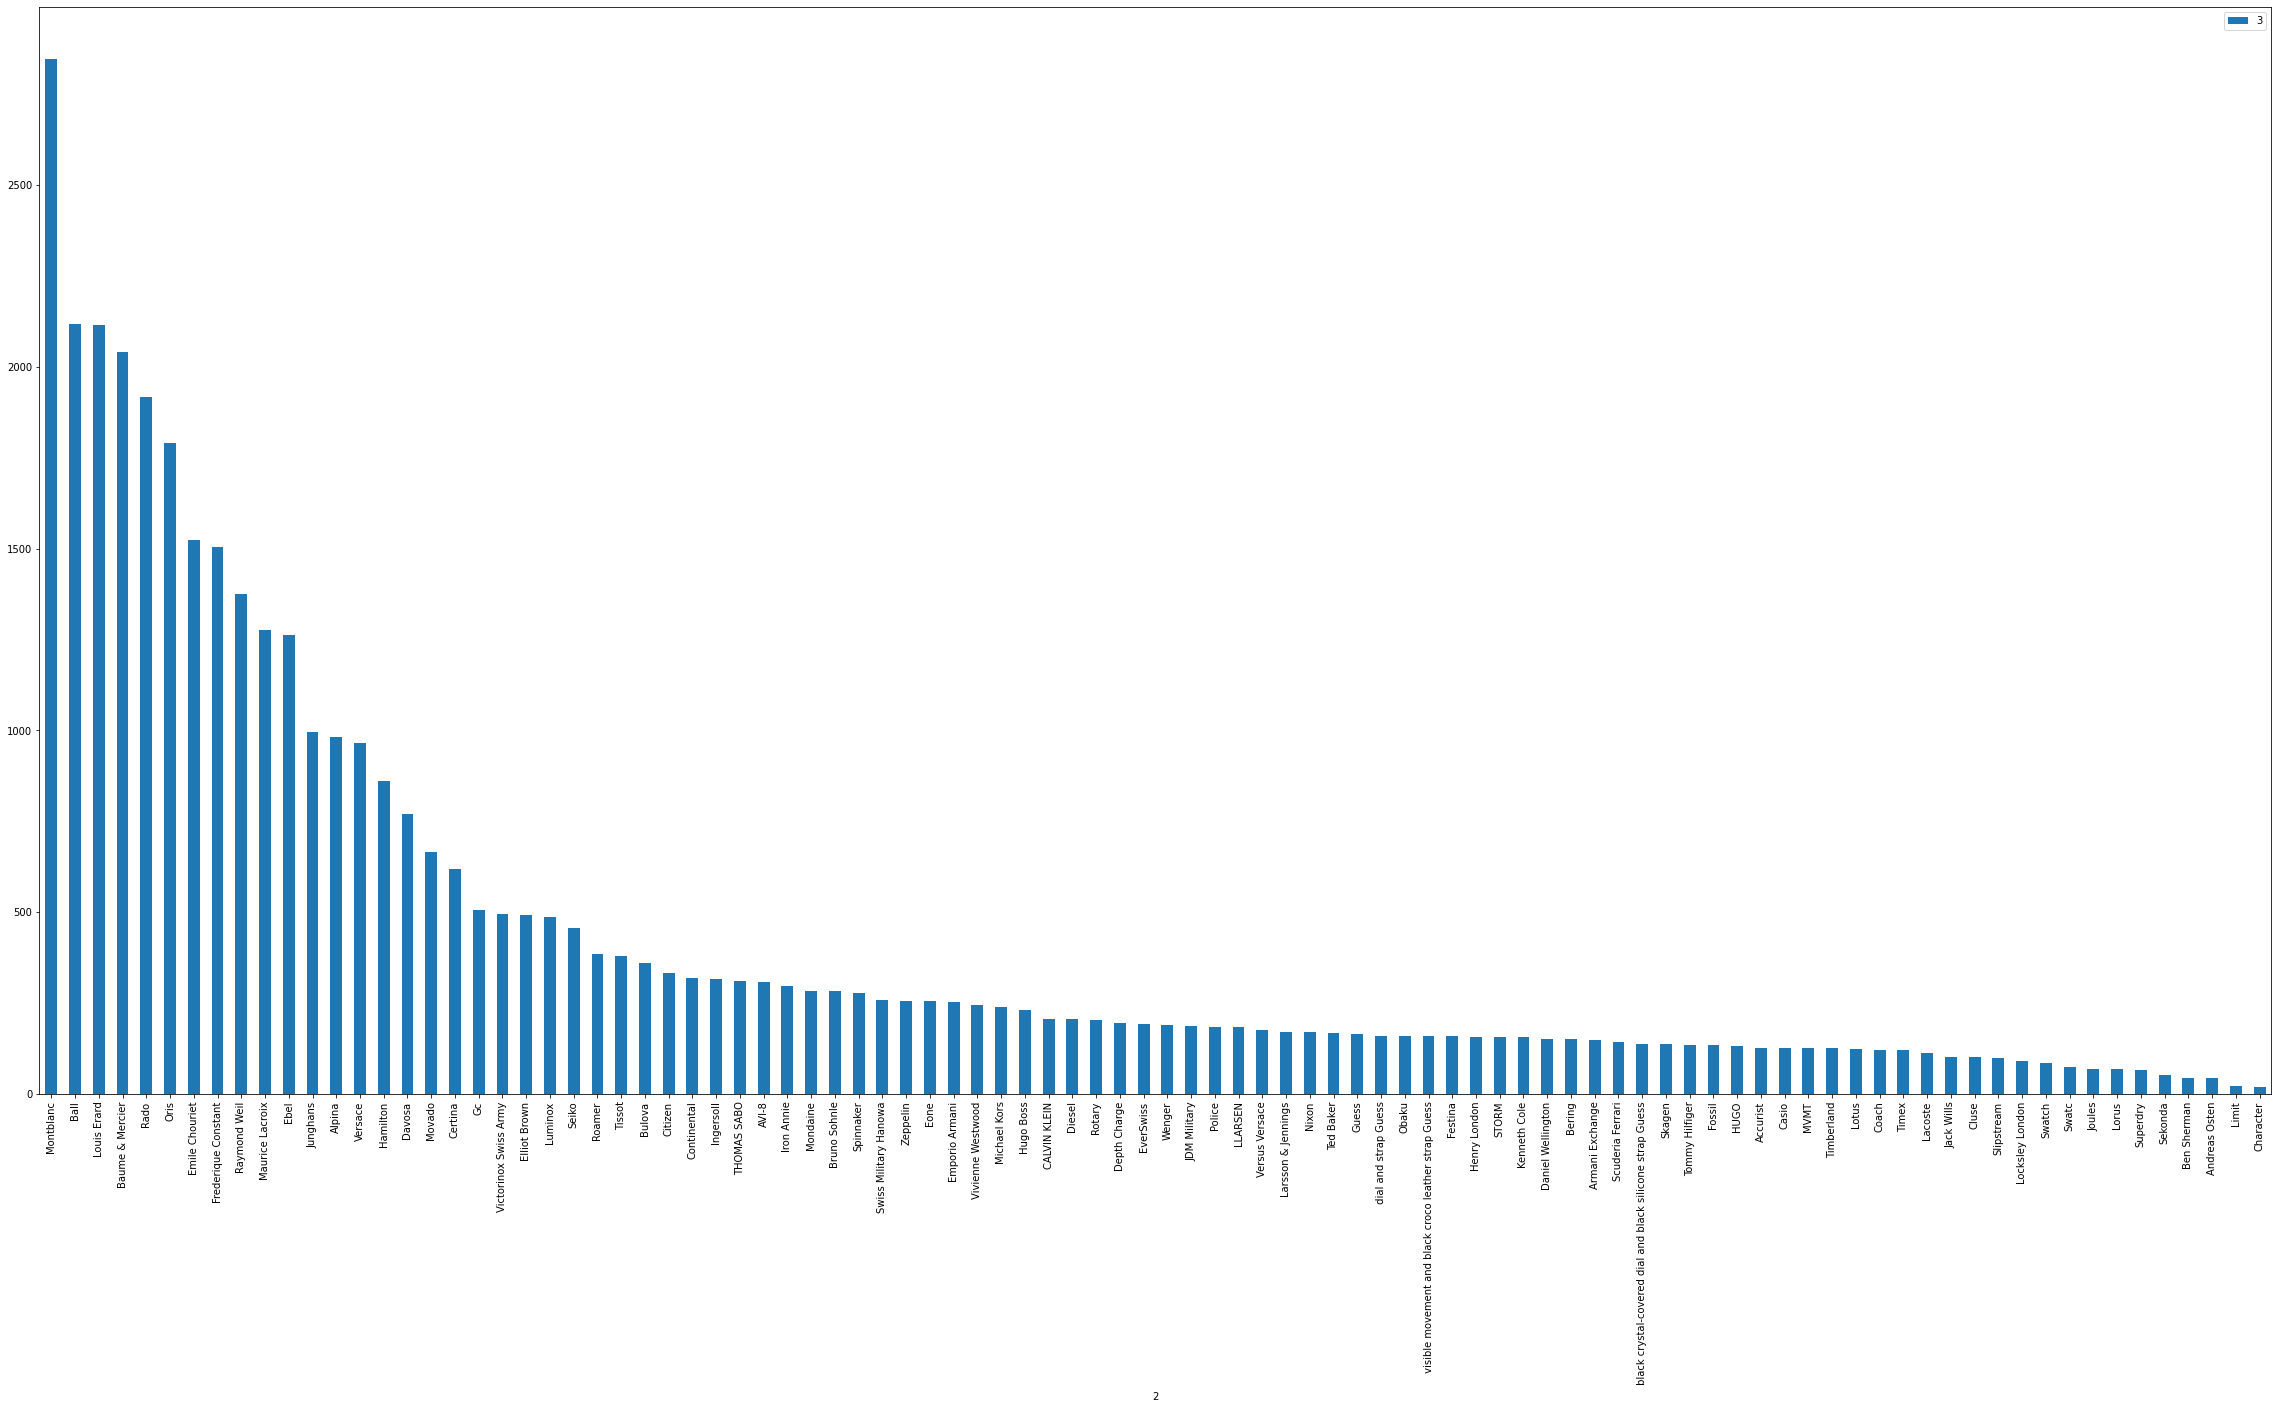

In [3]:
data[[3,2]].groupby(2).mean().sort_values(3, ascending=False).plot(kind='bar',figsize=(40,20))
data[[3,2]].groupby(2).mean().sort_values(3, ascending=False).head(10)

### 各品牌錶個數視覺化

<bound method DataFrame.items of                      3
2                     
Casio              181
Swatch             143
Seiko              137
Tissot             109
Citizen            105
Certina             99
Fossil              97
Timex               93
Emporio Armani      92
Rotary              86
Armani Exchange     81
Hamilton            79
Timberland          77
Festina             72
Diesel              69
Hugo Boss           67
Daniel Wellington   66
Bulova              65
STORM               65
Ingersoll           64>

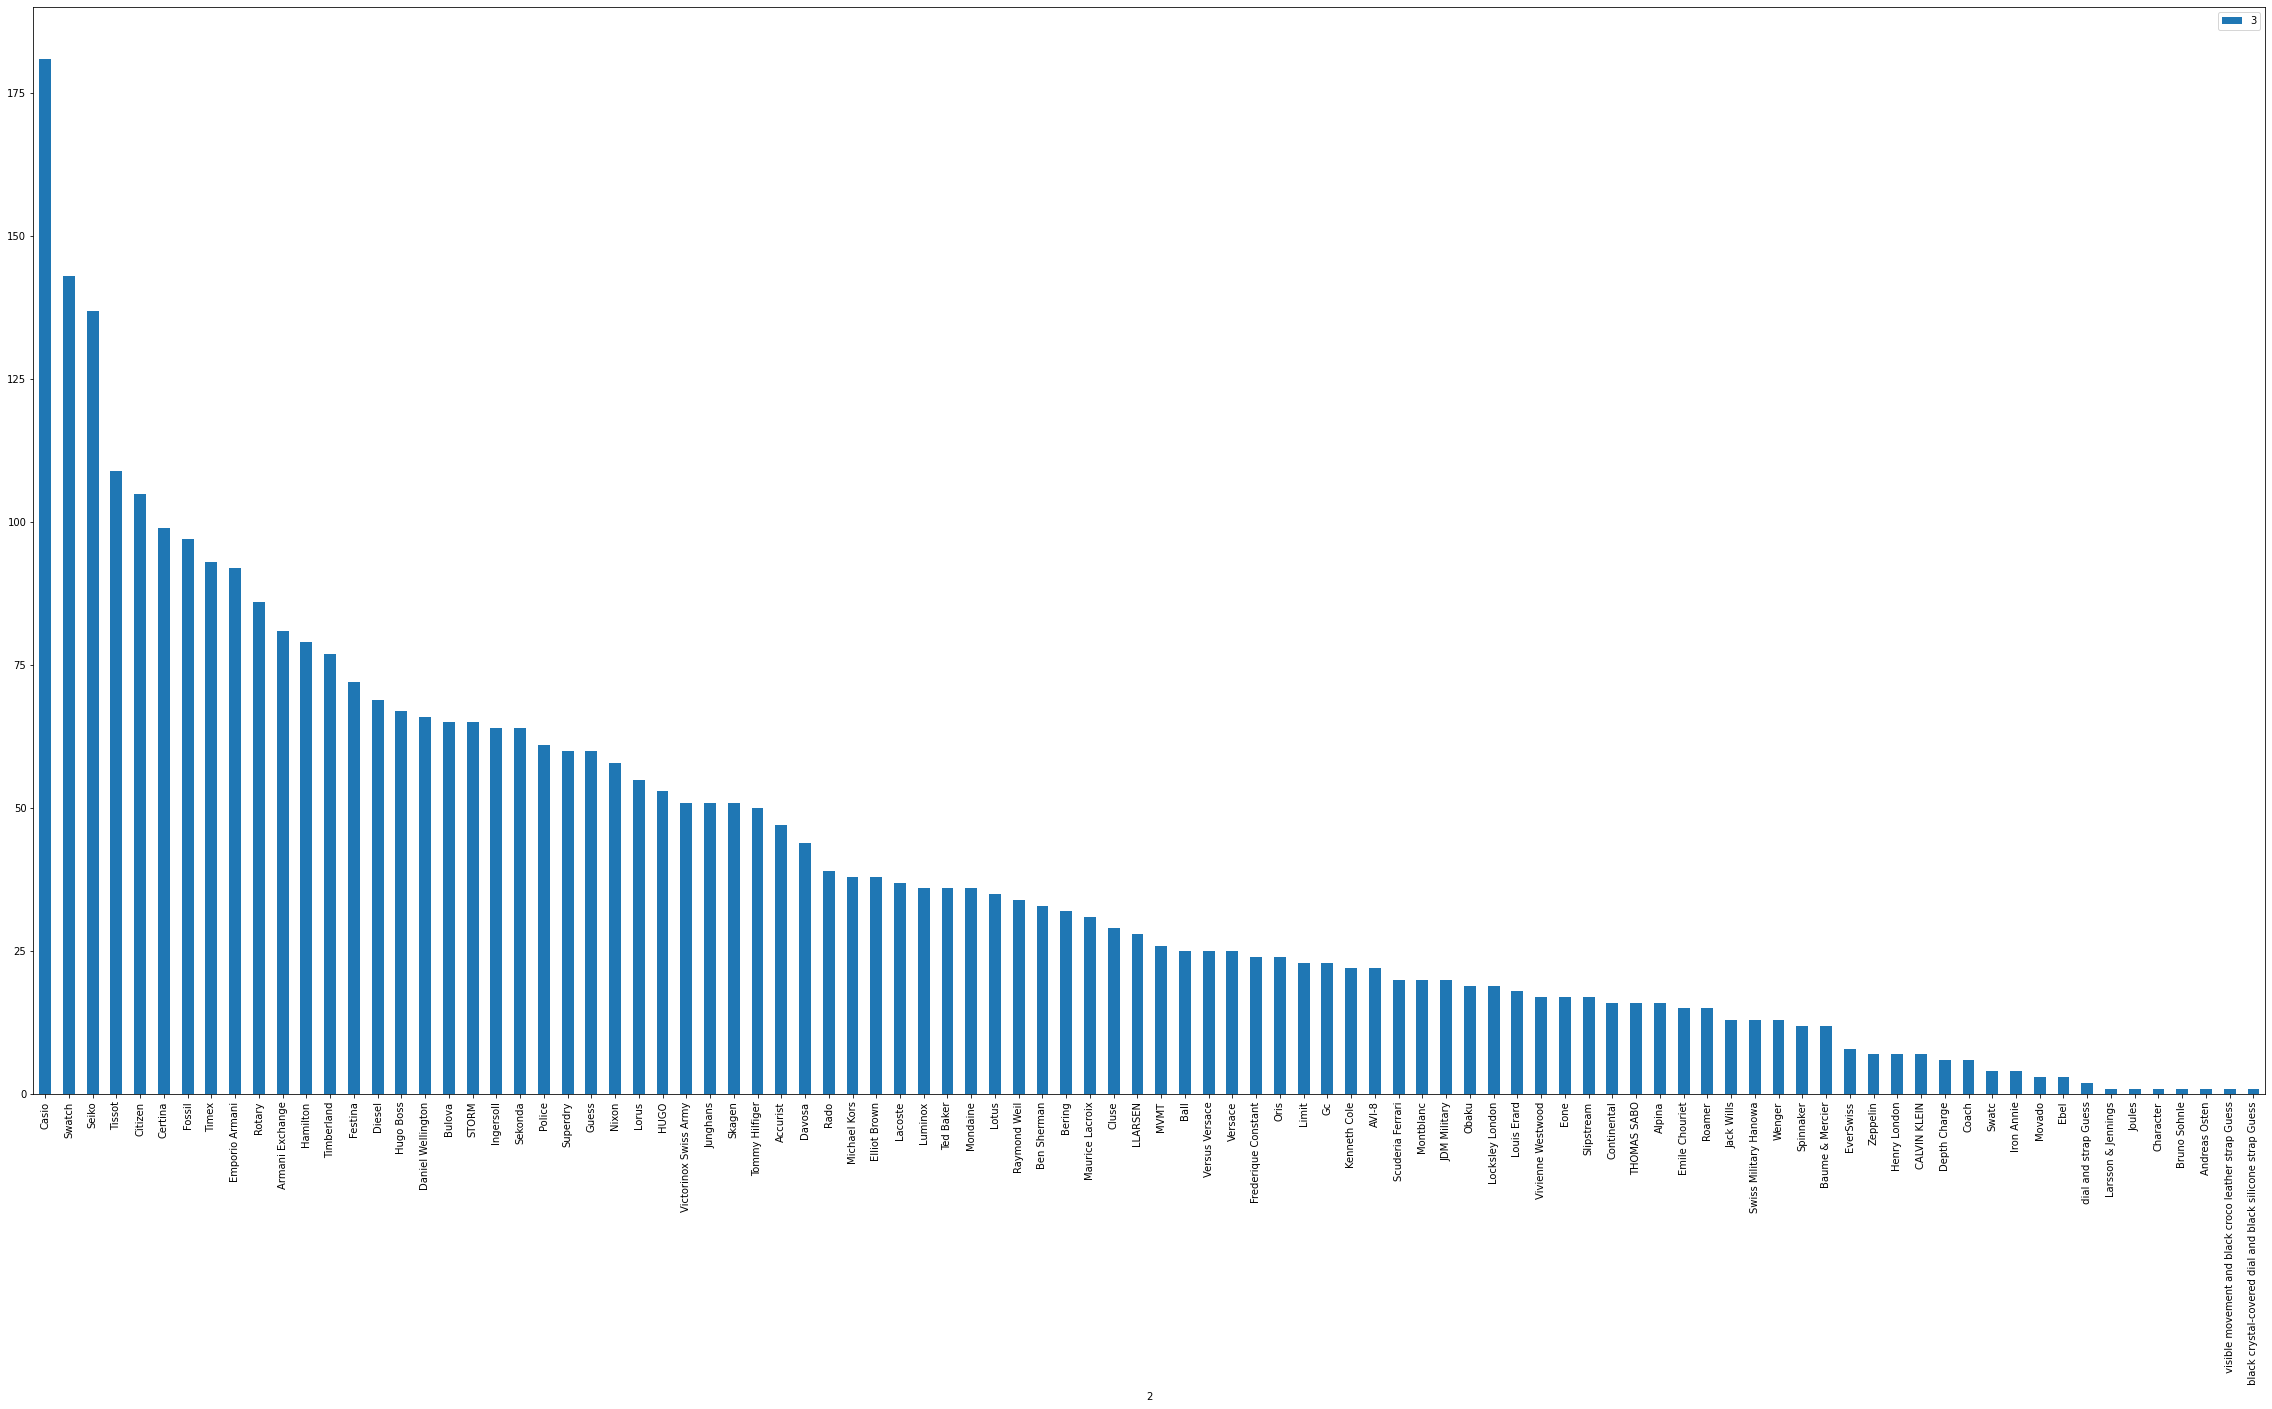

In [4]:
data[[3,2]].groupby(2).count().sort_values(3, ascending=False).plot(kind='bar',figsize=(40,20))
data[[3,2]].groupby(2).count().sort_values(3, ascending=False).head(20).items

## 品牌分類
挑選了手錶個數前25位的品牌進行分類  

In [5]:
img_data = []
img_arr = []
y = []

for filename in os.listdir(r"./brandimg"):
    img_data.append(filename.replace(".jpg","").split("_"))
    
img_pd = pd.DataFrame(img_data)
brand = img_pd[[2,1]].groupby(1).count().sort_values(2, ascending=False).head(25).index.tolist()

for filename in os.listdir(r"./brandimg"):
    if filename.replace(".jpg","").split("_")[1] in brand :   
        y.append(filename.replace(".jpg","").split("_")[1])
        img = cv2.imread("brandimg/" + filename)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
        img_arr.append(img)

X = np.array(img_arr)
brand_encoder = LabelEncoder()
y = np.array(brand_encoder.fit_transform(y))
brand = brand_encoder.classes_

### CNN 

Epoch 1/10
260/260 [==============================] - 13s 24ms/step - loss: 3.4318 - accuracy: 0.3478 - val_loss: 1.6234 - val_accuracy: 0.5807
Epoch 2/10
260/260 [==============================] - 6s 23ms/step - loss: 0.8038 - accuracy: 0.7871 - val_loss: 1.3290 - val_accuracy: 0.6637
Epoch 3/10
260/260 [==============================] - 6s 23ms/step - loss: 0.3807 - accuracy: 0.9268 - val_loss: 1.5981 - val_accuracy: 0.6457
Epoch 4/10
260/260 [==============================] - 6s 23ms/step - loss: 0.2178 - accuracy: 0.9441 - val_loss: 1.7468 - val_accuracy: 0.6839
Epoch 5/10
260/260 [==============================] - 6s 23ms/step - loss: 0.0998 - accuracy: 0.9769 - val_loss: 1.7426 - val_accuracy: 0.6951
Epoch 6/10
260/260 [==============================] - 6s 23ms/step - loss: 0.0607 - accuracy: 0.9855 - val_loss: 1.6601 - val_accuracy: 0.6771
Epoch 7/10
260/260 [==============================] - 6s 23ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 1.6982 - val_accuracy: 0.701

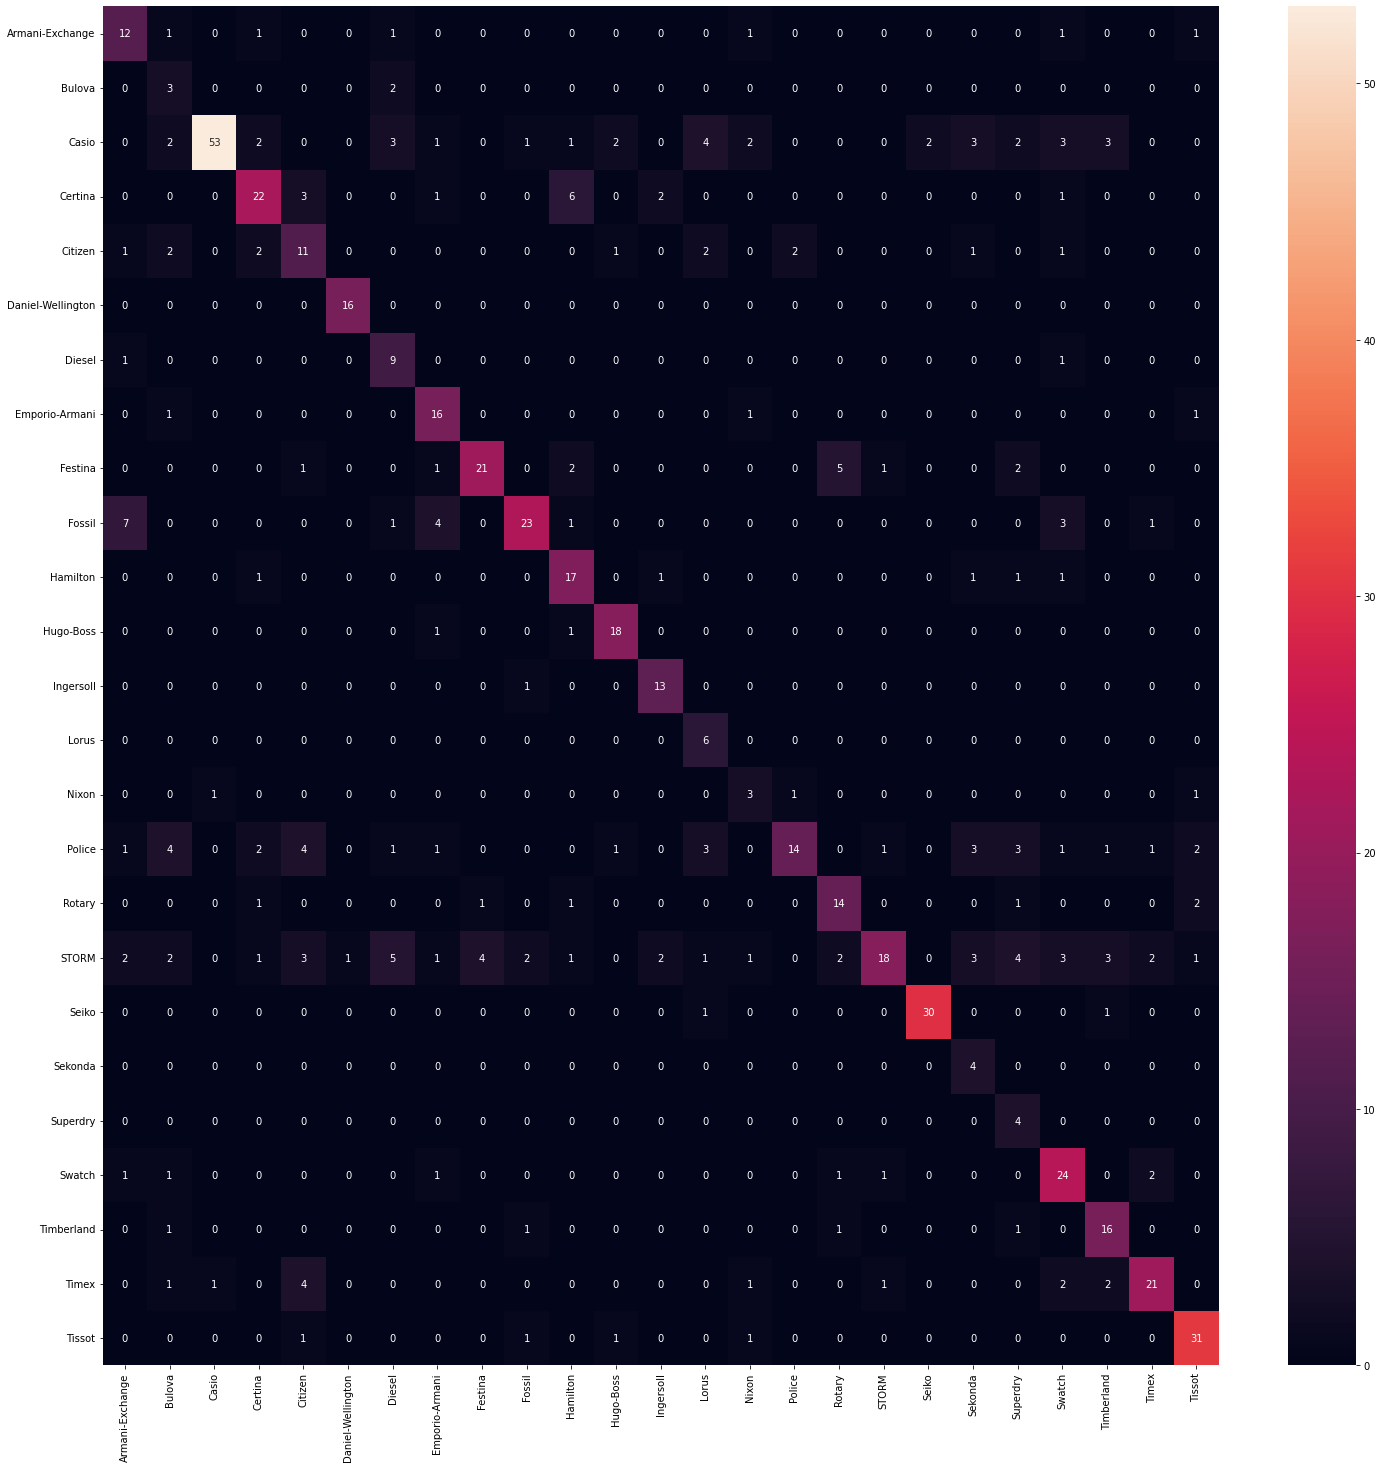

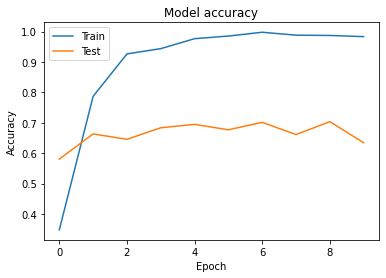

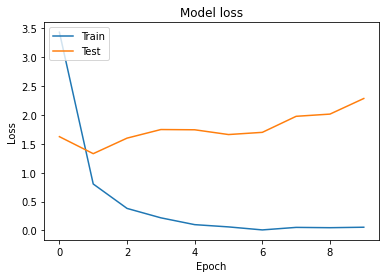

In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=177, shuffle=True)

brand_model = Sequential()
brand_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu'))
brand_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
brand_model.add(Flatten())
brand_model.add(Dense(units=500, kernel_initializer='normal', activation='relu')) 
brand_model.add(Dropout(0.5))
brand_model.add(Dense(units=25, kernel_initializer='normal', activation='softmax'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
brand_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

y_TrainOneHot = np_utils.to_categorical(y_train) 
y_TestOneHot = np_utils.to_categorical(y_test) 

# 將 training 的 input 資料轉為2維
X_train_2D = X_train.reshape(X_train.shape[0], 256, 256, 3).astype('float32')  
X_test_2D = X_test.reshape(X_test.shape[0], 256, 256, 3).astype('float32')  

x_Train_norm = X_train_2D/255.0
x_Test_norm = X_test_2D/255.0

# 進行訓練, 訓練過程會存在 train_history 變數中
history = brand_model.fit(x=x_Train_norm, y=y_TrainOneHot, validation_split=0.3, epochs=10, batch_size=4, verbose=1)  

# 顯示訓練成果(分數)
scores = brand_model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))  
ACC['brand_cnn'] = scores[1]

print()
table_predict = np.argmax(brand_model.predict(x_Test_norm), axis=-1)
table = PrettyTable()
table.add_column("Brand", brand)
table.add_column("Accuracy", np.full(25, round(accuracy_score(table_predict, y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(table_predict, y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(table_predict, y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(table_predict, y_test) , index = brand , columns = brand )
plt.figure(figsize = (25,25))
sn.heatmap(df_cm, annot=True)
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## 價格區間分類

In [7]:
img_arr = []
y = []
pri = []

for filename in os.listdir(r"./brandimg"):
    if int(filename.replace(".jpg","").split("_")[2]) < 250 :  
        y.append("1. 0-250")
    elif int(filename.replace(".jpg","").split("_")[2]) < 500 :
        y.append("2. 250-500")
    elif int(filename.replace(".jpg","").split("_")[2]) < 1000 :
        y.append("3. 500-1000")
    elif int(filename.replace(".jpg","").split("_")[2]) < 1250:
        y.append("4. 1000-1250")
    elif int(filename.replace(".jpg","").split("_")[2]) < 1500 :
        y.append("5. 1250-1500")
    else :
        y.append("6. 1500+")
    
    pri.append(int(filename.replace(".jpg","").split("_")[2]))
    img = cv2.imread("brandimg/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)

X = np.array(img_arr)

price_encoder = LabelEncoder()
y = np.array(price_encoder.fit_transform(y))
price = price_encoder.classes_

### 利用 TruncatedSVD + t-SNE 進行降維

<AxesSubplot:xlabel='Feature_1', ylabel='Feature_2'>

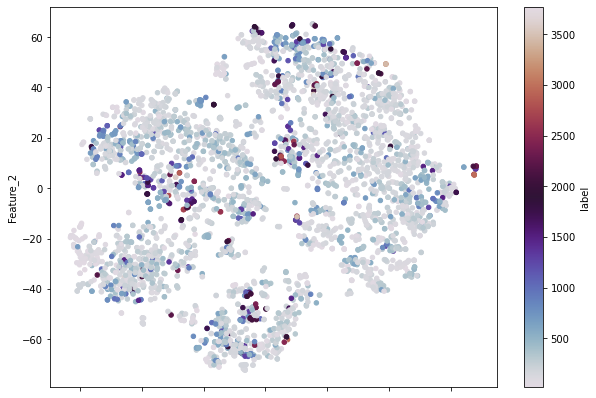

In [8]:
tsvd = TruncatedSVD(n_components=100).fit_transform(X.reshape(X.shape[0],-1))
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tsvd)

pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=pri )).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='twilight', figsize = (10,7))

### DecisionTree


+--------------+----------+-------------+-----------+
|   Classes    | Accuracy | Sensitivity | Precision |
+--------------+----------+-------------+-----------+
|   1. 0-250   |  0.6551  |    0.7524   |   0.8309  |
|  2. 250-500  |  0.6551  |    0.3952   |   0.3626  |
| 3. 500-1000  |  0.6551  |    0.4789   |   0.3778  |
| 4. 1000-1250 |  0.6551  |    0.1667   |    0.4    |
| 5. 1250-1500 |  0.6551  |     0.25    |   0.1111  |
|   6. 1500+   |  0.6551  |    0.8182   |   0.375   |
+--------------+----------+-------------+-----------+


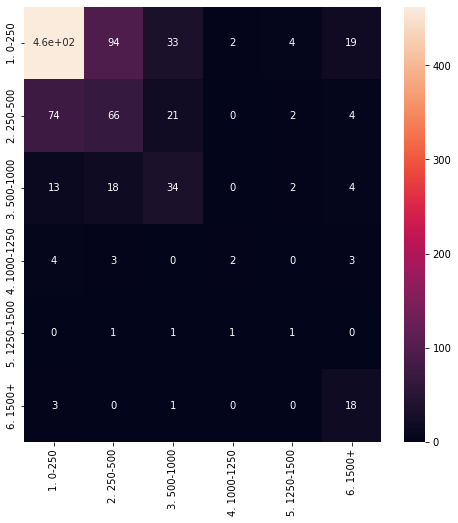

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=15, random_state=144)
clf.fit(X_train, y_train)

ACC['price_DecisionTree'] = accuracy_score(clf.predict(X_test), y_test)

print()
classes = price
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(6,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### CNN

Epoch 1/10
872/872 [==============================] - 4s 4ms/step - loss: 1.4055 - accuracy: 0.5955 - val_loss: 1.1764 - val_accuracy: 0.6573
Epoch 2/10
872/872 [==============================] - 3s 4ms/step - loss: 1.0119 - accuracy: 0.6707 - val_loss: 1.0034 - val_accuracy: 0.7015
Epoch 3/10
872/872 [==============================] - 3s 4ms/step - loss: 0.5968 - accuracy: 0.7849 - val_loss: 1.0575 - val_accuracy: 0.7269
Epoch 4/10
872/872 [==============================] - 3s 4ms/step - loss: 0.3272 - accuracy: 0.8853 - val_loss: 1.2939 - val_accuracy: 0.6881
Epoch 5/10
872/872 [==============================] - 3s 4ms/step - loss: 0.1909 - accuracy: 0.9403 - val_loss: 1.4338 - val_accuracy: 0.7216
Epoch 6/10
872/872 [==============================] - 3s 4ms/step - loss: 0.1183 - accuracy: 0.9662 - val_loss: 1.7365 - val_accuracy: 0.7095
Epoch 7/10
872/872 [==============================] - 3s 4ms/step - loss: 0.1097 - accuracy: 0.9679 - val_loss: 1.9921 - val_accuracy: 0.7189
Epoch 

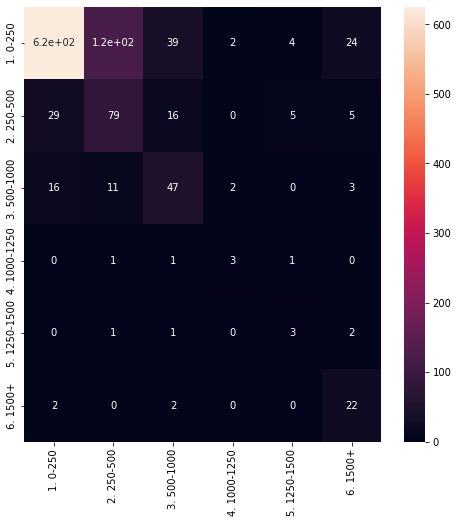

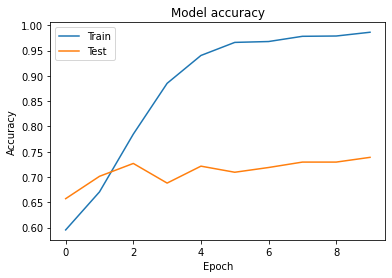

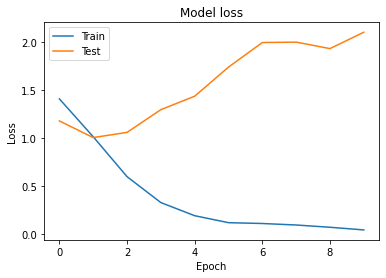

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=156, shuffle=True)

price_model = Sequential()
price_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu'))
price_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
price_model.add(MaxPooling2D(pool_size=(2, 2)))
price_model.add(Flatten())
price_model.add(Dropout(0.5))
price_model.add(Dense(units=6, kernel_initializer='normal', activation='softmax'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
price_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

y_TrainOneHot = np_utils.to_categorical(y_train) 
y_TestOneHot = np_utils.to_categorical(y_test) 

# 將 training 的 input 資料轉為2維
X_train_2D = X_train.reshape(X_train.shape[0], 256, 256, 3).astype('float32')  
X_test_2D = X_test.reshape(X_test.shape[0], 256, 256, 3).astype('float32')  

x_Train_norm = X_train_2D/255.0
x_Test_norm = X_test_2D/255.0

# 進行訓練, 訓練過程會存在 train_history 變數中
history = price_model.fit(x=x_Train_norm, y=y_TrainOneHot, validation_split=0.3, epochs=10, batch_size=2, verbose=1)  

# 顯示訓練成果(分數)
scores = price_model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))  
ACC['price_cnn'] = scores[1]

print()
table_predict = np.argmax(price_model.predict(x_Test_norm), axis=-1)
table = PrettyTable()
table.add_column("Classes", price)
table.add_column("Accuracy", np.full(6,round(accuracy_score(table_predict, y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(table_predict, y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(table_predict, y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(table_predict, y_test) , index = price , columns = price )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## 類別分析 (男錶, 女錶)

In [11]:
img_arr = []
y = []

for filename in os.listdir(r"./brandimg"):
    y.append(0)
    img = cv2.imread("brandimg/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)
    
for filename in os.listdir(r"./lbrandimg"):
    y.append(1)
    img = cv2.imread("lbrandimg/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)

X = np.array(img_arr)
X = X.reshape(X.shape[0],-1)

### DecisionTree


+---------+----------+-------------+-----------+
| Classes | Accuracy | Sensitivity | Precision |
+---------+----------+-------------+-----------+
|   Mens  |  0.8097  |    0.7835   |   0.8663  |
|  Ladies |  0.8097  |    0.8436   |   0.7509  |
+---------+----------+-------------+-----------+


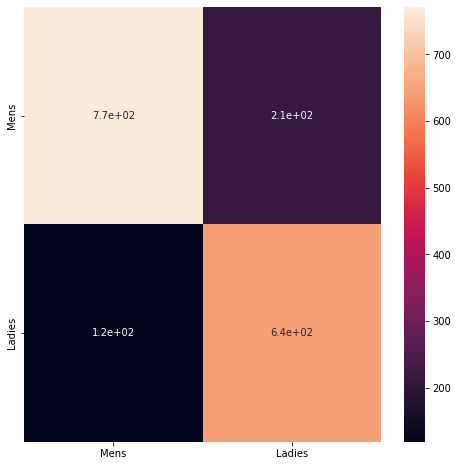

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=77, shuffle=True)

clf = DecisionTreeClassifier(max_depth=3, random_state=144)
clf.fit(X_train, y_train)
ACC['classml_DecisionTree'] = accuracy_score(clf.predict(X_test), y_test)

print()
classes = ["Mens", "Ladies"]
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(2,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### 利用 TruncatedSVD + t-SNE 進行降維

<AxesSubplot:xlabel='Feature_1', ylabel='Feature_2'>

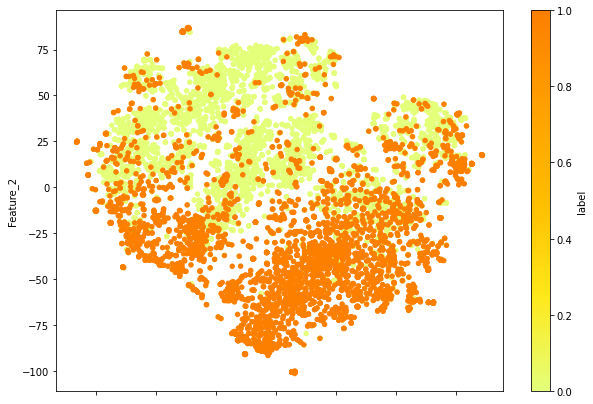

In [13]:
tsvd = TruncatedSVD(n_components=100).fit_transform(X)
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tsvd)
pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', figsize = (10,7))

### DecisionTree


+---------+----------+-------------+-----------+
| Classes | Accuracy | Sensitivity | Precision |
+---------+----------+-------------+-----------+
|   Mens  |  0.8315  |    0.8157   |   0.8685  |
|  Ladies |  0.8315  |    0.8506   |   0.7925  |
+---------+----------+-------------+-----------+


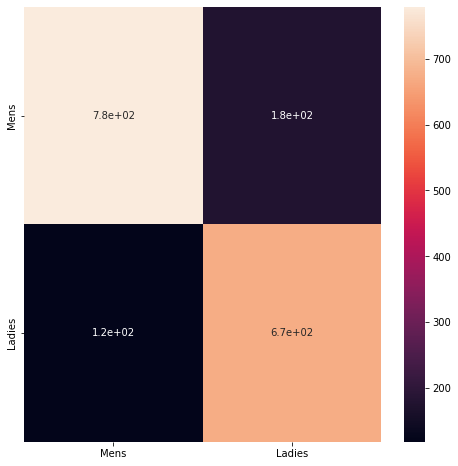

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne, y, test_size=0.25, random_state=156, shuffle=True)

classml_clf = DecisionTreeClassifier(max_depth=6, random_state=144)
classml_clf.fit(X_train, y_train)
ACC['classml_DecisionTree_TruncatedSVD100'] = accuracy_score(classml_clf.predict(X_test), y_test)

print()
classes = ["Mens", "Ladies"]
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(2,round(accuracy_score(classml_clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(classml_clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(classml_clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(classml_clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

## 類別分析 (計時錶, 數位錶, 自動錶, 運動錶)

In [15]:
img_arr = []
y = []

for filename in os.listdir(r"./chronograph"):
    y.append("chronograph")
    img = cv2.imread("chronograph/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)
    
for filename in os.listdir(r"./digital"):
    y.append("digital")
    img = cv2.imread("digital/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)

for filename in os.listdir(r"./automatic"):
    y.append("automatic")
    img = cv2.imread("automatic/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)
    
for filename in os.listdir(r"./sports"):
    y.append("sports")
    img = cv2.imread("sports/" + filename)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img_arr.append(img)

X = np.array(img_arr)
X = X.reshape(X.shape[0],-1)

label_encoder = LabelEncoder()
y = np.array(label_encoder.fit_transform(y))
classes = label_encoder.classes_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=77, shuffle=True)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=4, kernel_initializer='normal', activation='softmax'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

y_TrainOneHot = np_utils.to_categorical(y_train) 
y_TestOneHot = np_utils.to_categorical(y_test) 

# 將 training 的 input 資料轉為2維
X_train_2D = X_train.reshape(X_train.shape[0], 256, 256, 3).astype('float32')  
X_test_2D = X_test.reshape(X_test.shape[0], 256, 256, 3).astype('float32')  

x_Train_norm = X_train_2D/255.0
x_Test_norm = X_test_2D/255.0

# 進行訓練, 訓練過程會存在 train_history 變數中
history = model.fit(x=x_Train_norm, y=y_TrainOneHot, validation_split=0.3, epochs=10, batch_size=4, verbose=1)  

# 顯示訓練成果(分數)
scores = model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))  

print()
table_predict = np.argmax(model.predict(x_Test_norm), axis=-1)
table = PrettyTable()
table.add_column("classes", classes)
table.add_column("Accuracy", np.full(4, round(accuracy_score(table_predict, y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(table_predict, y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(table_predict, y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(table_predict, y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

![](https://i.imgur.com/tm6Rh8F.png)

### 利用 PCA 進行降維

<AxesSubplot:xlabel='Feature_1', ylabel='Feature_2'>

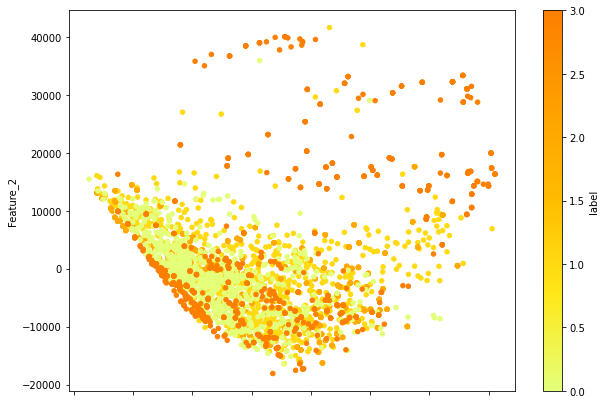

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pd.DataFrame(dict(Feature_1=X_pca[:,0], Feature_2=X_pca[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', figsize = (10,7) )

### DecisionTree


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.7244  |    0.674    |   0.6429  |
| chronograph |  0.7244  |    0.6139   |   0.4273  |
|   digital   |  0.7244  |    0.7752   |   0.9804  |
|    sports   |  0.7244  |    0.7915   |    0.89   |
+-------------+----------+-------------+-----------+


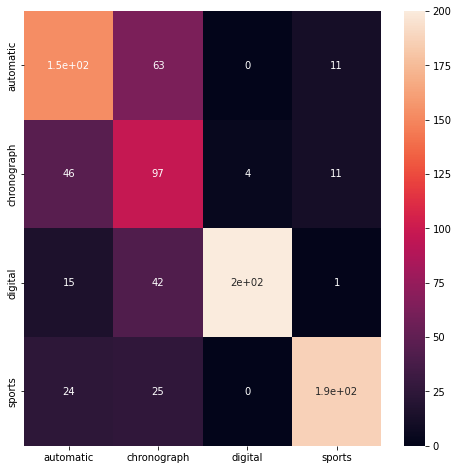

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X_pca, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=20, random_state=144)
clf.fit(X_train, y_train)
ACC['classes_DecisionTree_PCA'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### 利用 t-SNE 進行降維

<AxesSubplot:xlabel='Feature_1', ylabel='Feature_2'>

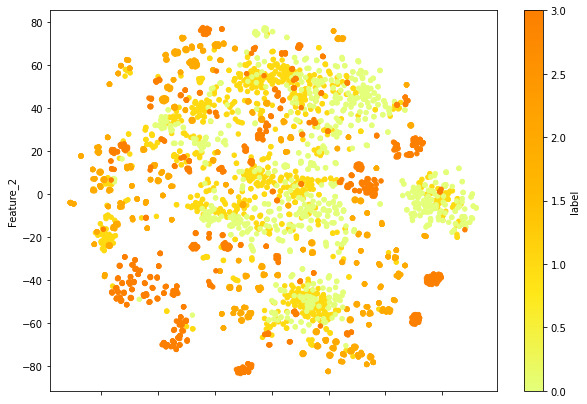

In [18]:
X_puretsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
pd.DataFrame(dict(Feature_1=X_puretsne[:,0], Feature_2=X_puretsne[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', figsize = (10,7))

### DecisionTree


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.8155  |    0.8402   |   0.7731  |
| chronograph |  0.8155  |    0.6569   |   0.6916  |
|   digital   |  0.8155  |    0.8436   |   0.8725  |
|    sports   |  0.8155  |    0.9426   |   0.9426  |
+-------------+----------+-------------+-----------+


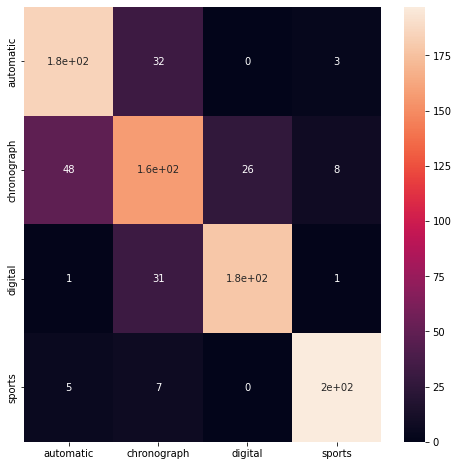

In [19]:
X_train, X_test, y_train, y_test = train_test_split( X_puretsne, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=20, random_state=144)
clf.fit(X_train, y_train)
ACC['classes_DecisionTree_TSNE'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### 利用 TruncatedSVD + t-SNE 進行降維
比對 採用不同 n_components 的 TruncatedSVD 

array([<AxesSubplot:title={'center':'n_components = 50'}, xlabel='Feature_1', ylabel='Feature_2'>],
      dtype=object)

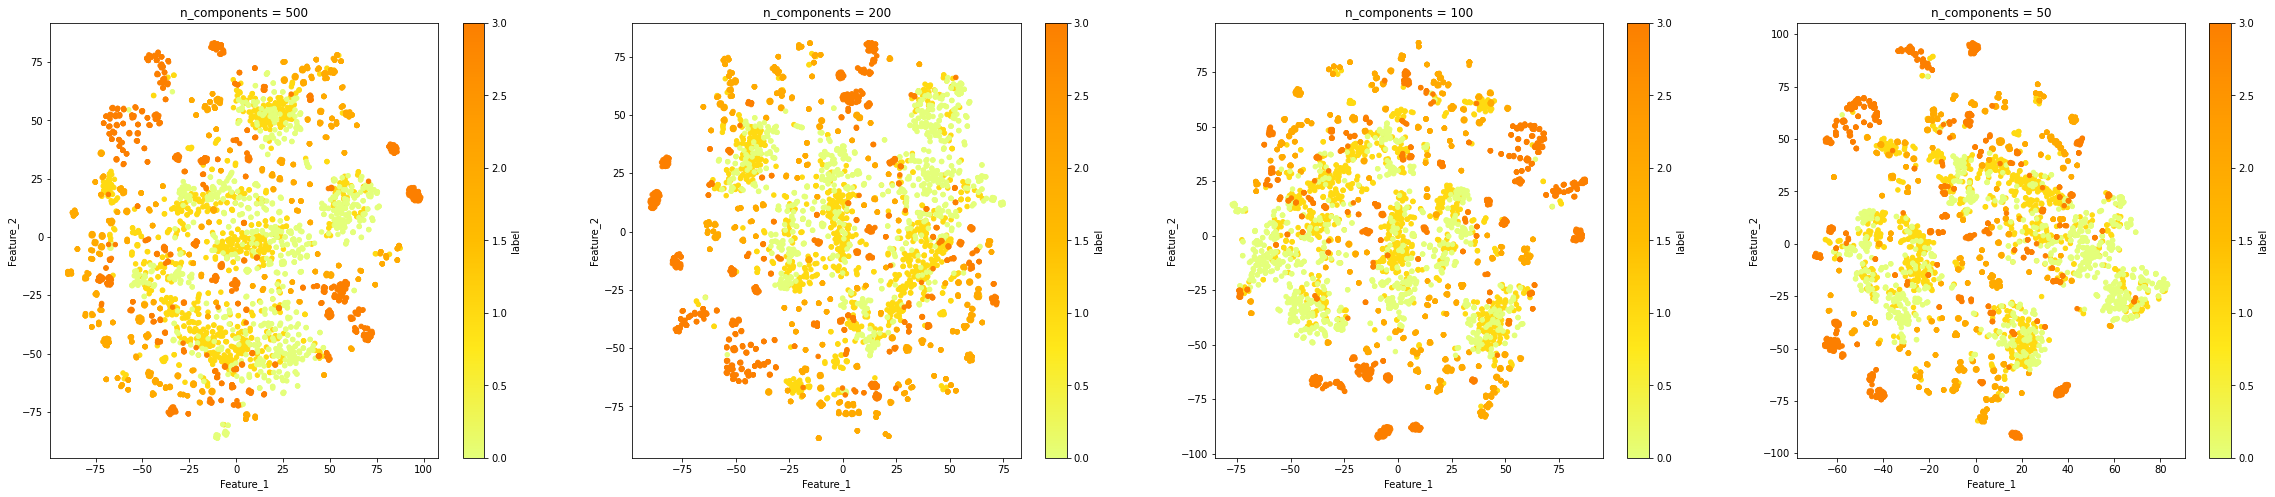

In [20]:
tsvd50 = TruncatedSVD(n_components=50).fit_transform(X)
X_tsne50 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tsvd50)

tsvd100 = TruncatedSVD(n_components=100).fit_transform(X)
X_tsne100 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tsvd100)

tsvd200 = TruncatedSVD(n_components=200).fit_transform(X)
X_tsne200 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tsvd200)

tsvd500 = TruncatedSVD(n_components=500).fit_transform(X)
X_tsne500 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tsvd500)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (40,8))
axes[0].set_title('n_components = 500')
pd.DataFrame(dict(Feature_1=X_tsne500[:,0], Feature_2=X_tsne500[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', subplots=True ,ax=axes[0])
axes[1].set_title('n_components = 200')
pd.DataFrame(dict(Feature_1=X_tsne200[:,0], Feature_2=X_tsne200[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', subplots=True ,ax=axes[1])
axes[2].set_title('n_components = 100')
pd.DataFrame(dict(Feature_1=X_tsne100[:,0], Feature_2=X_tsne100[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', subplots=True ,ax=axes[2])
axes[3].set_title('n_components = 50')
pd.DataFrame(dict(Feature_1=X_tsne50[:,0], Feature_2=X_tsne50[:,1], label=y)).plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='Wistia', subplots=True ,ax=axes[3])

### DecisionTree


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.8109  |    0.7956   |   0.7521  |
| chronograph |  0.8109  |    0.6637   |   0.652   |
|   digital   |  0.8109  |    0.8632   |   0.8971  |
|    sports   |  0.8109  |    0.9266   |   0.9665  |
+-------------+----------+-------------+-----------+


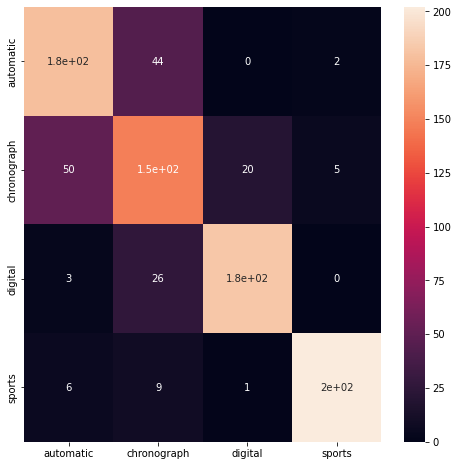

In [21]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne50, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=20, random_state=144)
clf.fit(X_train, y_train)
ACC['classes_DecisionTree_TruncatedSVD50'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.7984  |    0.7737   |   0.7899  |
| chronograph |  0.7984  |    0.6584   |   0.5859  |
|   digital   |  0.7984  |    0.8286   |   0.8529  |
|    sports   |  0.7984  |    0.9238   |   0.9856  |
+-------------+----------+-------------+-----------+


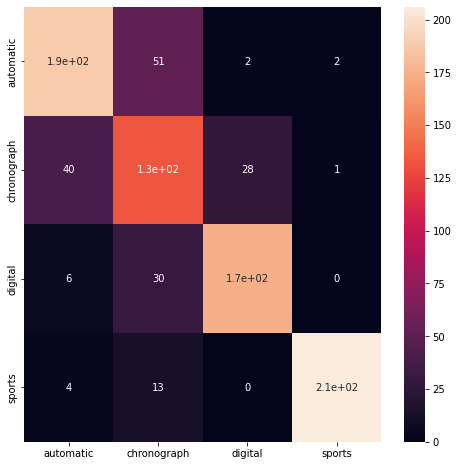

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne100, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=20, random_state=144)
clf.fit(X_train, y_train)
ACC['classes_DecisionTree_TruncatedSVD100'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.8178  |    0.8062   |   0.7689  |
| chronograph |  0.8178  |    0.6787   |   0.6608  |
|   digital   |  0.8178  |    0.866    |   0.8873  |
|    sports   |  0.8178  |    0.9231   |   0.9761  |
+-------------+----------+-------------+-----------+


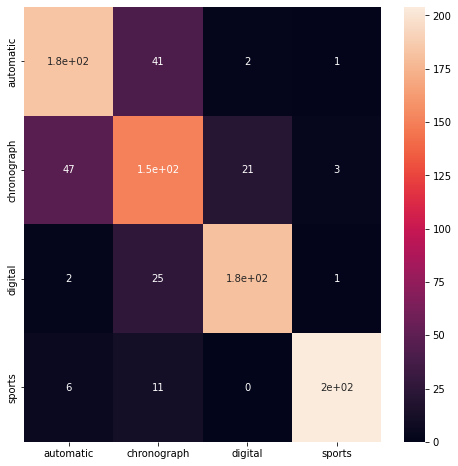

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne200, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=26, random_state=144)
clf.fit(X_train, y_train)
ACC['classes_DecisionTree_TruncatedSVD200'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.8417  |    0.8421   |   0.8067  |
| chronograph |  0.8417  |    0.7346   |   0.6828  |
|   digital   |  0.8417  |    0.8591   |   0.9265  |
|    sports   |  0.8417  |    0.9269   |   0.9713  |
+-------------+----------+-------------+-----------+


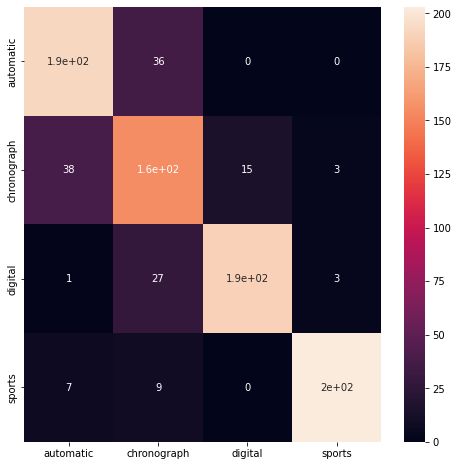

In [24]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne500, y, test_size=0.25, random_state=156, shuffle=True)

clf = DecisionTreeClassifier(max_depth=24, random_state=144)
clf.fit(X_train, y_train)
ACC['classes_DecisionTree_TruncatedSVD500'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### SVM


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.582   |    0.5871   |   0.4958  |
| chronograph |  0.582   |    0.4335   |   0.6608  |
|   digital   |  0.582   |    0.6928   |   0.5637  |
|    sports   |  0.582   |    0.7758   |   0.6124  |
+-------------+----------+-------------+-----------+


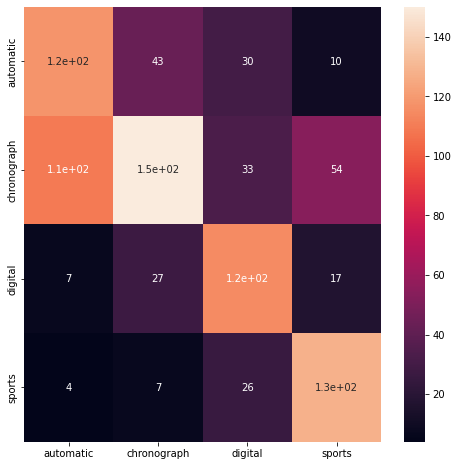

In [25]:
X_train, X_test, y_train, y_test = train_test_split( X_tsne500, y, test_size=0.25, random_state=156, shuffle=True)

clf = SVC()
clf.fit(X_train, y_train)
ACC['classes_SVM'] = accuracy_score(clf.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(clf.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(clf.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(clf.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### XGBoost

[22:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.8405  |    0.8174   |   0.7521  |
| chronograph |  0.8405  |    0.7261   |   0.7357  |
|   digital   |  0.8405  |    0.8772   |   0.9804  |
|    sports   |  0.8405  |    0.9552   |   0.9187  |
+-------------+----------+-------------+-----------+


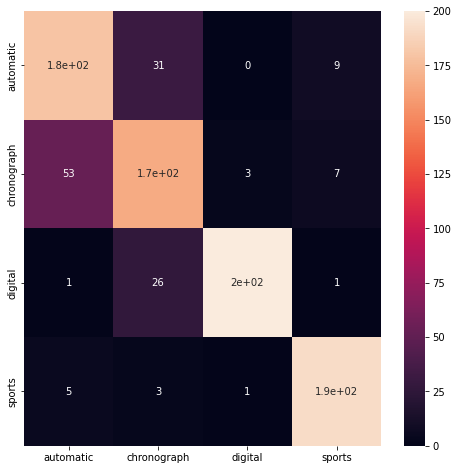

In [26]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.25, tree_method='gpu_hist', gpu_id=0)
xgboostModel.fit(X_train, y_train)
ACC['classes_xgboost'] = accuracy_score(xgboostModel.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(xgboostModel.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(xgboostModel.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(xgboostModel.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(xgboostModel.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

### LightGBM


+-------------+----------+-------------+-----------+
|   Classes   | Accuracy | Sensitivity | Precision |
+-------------+----------+-------------+-----------+
|  automatic  |  0.8485  |    0.8436   |   0.7479  |
| chronograph |  0.8485  |    0.7082   |   0.7269  |
|   digital   |  0.8485  |    0.8924   |   0.9755  |
|    sports   |  0.8485  |    0.9621   |   0.9713  |
+-------------+----------+-------------+-----------+


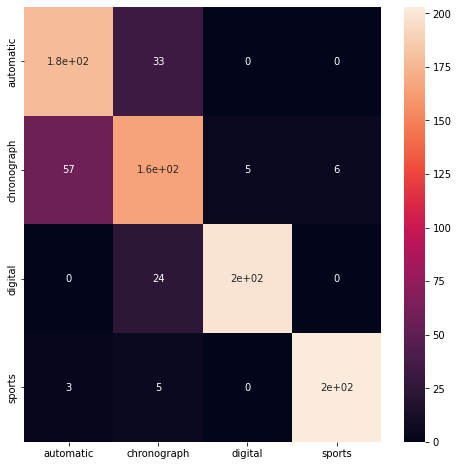

In [27]:
gbm = LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=1000, device='gpu')
gbm.fit(X_train, y_train)
ACC['classes_gbm'] = accuracy_score(gbm.predict(X_test), y_test)

print()
table = PrettyTable()
table.add_column("Classes", classes )
table.add_column("Accuracy", np.full(4,round(accuracy_score(gbm.predict(X_test), y_test),4)) )
table.add_column("Sensitivity",  np.round(recall_score(gbm.predict(X_test), y_test, average=None ), decimals = 4))
table.add_column("Precision", np.round(precision_score(gbm.predict(X_test), y_test, average=None ), decimals = 4))
print(table)

df_cm = pd.DataFrame(confusion_matrix(gbm.predict(X_test), y_test) , index = classes , columns = classes )
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
plt.show()

## Results

In [28]:
print("-"*20)
print("品牌")
print("-"*20)
table = PrettyTable()
table.field_names = ["Model", "Accuracy"] 
table.add_row(["CNN", round(ACC['brand_cnn'],4)])
print(table)
print()

print("-"*20)
print("價格區間")
print("-"*20)
table = PrettyTable()
table.field_names = ["Model", "Accuracy"] 
table.add_row(["DecisionTree", round(ACC['price_DecisionTree'],4)])
table.add_row(["CNN", round(ACC['price_cnn'],4)])
print(table)
print()

print("-"*20)
print("類別 (男錶, 女錶)")
print("-"*20)
table = PrettyTable()
table.field_names = ["Model", "Accuracy"] 
table.add_row(["DecisionTree", round(ACC['classml_DecisionTree'],4)])
table.add_row(["DecisionTree with TruncatedSVD(100)+t-SNE", round(ACC['classml_DecisionTree_TruncatedSVD100'],4)])
print(table)
print()

print("-"*20)
print("類別 (計時錶, 數位錶, 自動錶, 運動錶)")
print("-"*20)
table = PrettyTable()
table.field_names = ["Model", "Accuracy"] 
table.add_row(["DecisionTree with PCA", round(ACC['classes_DecisionTree_PCA'],4)])
table.add_row(["DecisionTree with TSNE", round(ACC['classes_DecisionTree_TSNE'],4)])
table.add_row(["DecisionTree with TruncatedSVD(50)+t-SNE", round(ACC['classes_DecisionTree_TruncatedSVD50'],4)])
table.add_row(["DecisionTree with TruncatedSVD(100)+t-SNE", round(ACC['classes_DecisionTree_TruncatedSVD100'],4)])
table.add_row(["DecisionTree with TruncatedSVD(200)+t-SNE", round(ACC['classes_DecisionTree_TruncatedSVD200'],4)])
table.add_row(["DecisionTree with TruncatedSVD(500)+t-SNE", round(ACC['classes_DecisionTree_TruncatedSVD500'],4)])
table.add_row(["SVM", round(ACC['classes_SVM'],4)])
table.add_row(["XGBoost", round(ACC['classes_xgboost'],4)])
table.add_row(["LightGBM", round(ACC['classes_gbm'],4)])
print(table)

--------------------
品牌
--------------------
+-------+----------+
| Model | Accuracy |
+-------+----------+
|  CNN  |  0.6588  |
+-------+----------+

--------------------
價格區間
--------------------
+--------------+----------+
|    Model     | Accuracy |
+--------------+----------+
| DecisionTree |  0.6551  |
|     CNN      |  0.7294  |
+--------------+----------+

--------------------
類別 (男錶, 女錶)
--------------------
+-------------------------------------------+----------+
|                   Model                   | Accuracy |
+-------------------------------------------+----------+
|                DecisionTree               |  0.8097  |
| DecisionTree with TruncatedSVD(100)+t-SNE |  0.8315  |
+-------------------------------------------+----------+

--------------------
類別 (計時錶, 數位錶, 自動錶, 運動錶)
--------------------
+-------------------------------------------+----------+
|                   Model                   | Accuracy |
+-------------------------------------------+----------+

### **小小測試環節**
拿起我身邊唯一的手錶對他拍照進行測試  
預測結果竟然剛好都有命中  
本次測試並不代表模型的好壞  
但可以稍微地相信他有一定的辨識能力

品牌辨識 : 
['Tissot']

價格區間預測 : 
['1. 0-250']



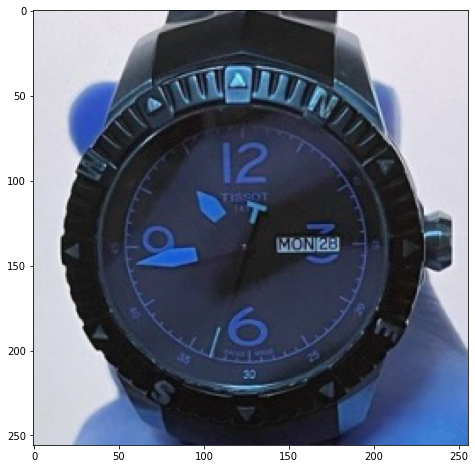

In [40]:
img = cv2.imread('test1.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
plt.figure(figsize = (8,8))
plt.imshow(img)

print("品牌辨識 : ")
print(brand_encoder.inverse_transform(np.argmax(brand_model.predict(np.array(img).reshape(1, 256, 256, 3).astype('float32')/255.0  ), axis=-1)))
print()
print("價格區間預測 : ")
print(price_encoder.inverse_transform(np.argmax(price_model.predict(np.array(img).reshape(1, 256, 256, 3).astype('float32')/255.0  ), axis=-1)))
print()

## Conclusion

- **不算多的資料集**   
    對於圖片辨識的首要課題就是如何蒐集足夠多的圖片進行訓練並預測，我認為以這次不到五千張圖片的資料集來看，如果有更多的圖片加入訓練應該會得到更好的結果  



  
- **圖片對於不是神經網路的訓練必須先經過降維處理**  
    由於圖片大小的關係，要直接丟入訓練模型中會導致記憶體不足的問題，因此要先進行資料降維。在資料降維的過程中，如何保有我們需要的特徵是一門大學問。  
    因此在這次的研究中，我一共採用了三種降維方式，分別為 PCA 、 t-SNE 以及 TruncatedSVD + t-SNE  
    經過比對之後發現 TruncatedSVD + t-SNE 的表現最佳  
    在進一步調整 TruncatedSVD 的 n_components 之後，發現 n_components=500 的時候準確率最高  
    如果不是資料訓練不動，我想原始的檔案直接拿來分裂鰾線應該會是最好，但不得已需要降維時處理 TruncatedSVD + t-SNE 的表現會是最佳的  



- **圖片與價格的線性關係不明顯**  
    除了做價格區間以外，我在本次的研究中有做過線性預測價格，但是效果很差。  
    換過了幾個回歸預測模型都沒有得到預期的效果，經過資料散佈圖的觀察，我認為是因為圖片與價格的線性關係不夠明顯導致。  


- **CNN 無法執行太多次**  
    本來要在所有的分析都用上CNN，無奈CNN訓練過程太吃 VRAM，即使是用上了3080依舊還是吃不消。  
    最後解決的方法是在有些項目放棄使用CNN進行分析，這是我覺得比較可惜的點。




   
      
- **LightGBM 以些微差距領先其他分類器**  
    作為 XGBoost 的近親，兩者都是以 GBDT 為基礎衍生的架構，LightGBM 以較高的準確率打敗了 傳統DecisionTree、SVM 以及 XGBoost。